C:\Users\josit\AppData\Local\Temp\ipykernel_34800\3925218869.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eth = yf.download("ETH-USD", start="2017-01-01", interval="1d")
[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open      Volume
Ticker         ETH-USD     ETH-USD     ETH-USD     ETH-USD     ETH-USD
Date                                                                  
2017-11-09  320.884003  329.451996  307.056000  308.644989   893249984
2017-11-10  299.252991  324.717987  294.541992  320.670990   885985984
2017-11-11  314.681000  319.453003  298.191986  298.585999   842300992
2017-11-12  307.907990  319.153015  298.513000  314.690002  1613479936
2017-11-13  316.716003  328.415009  307.024994  307.024994  1041889984
✅ Datos guardados como ethereum_historico.csv


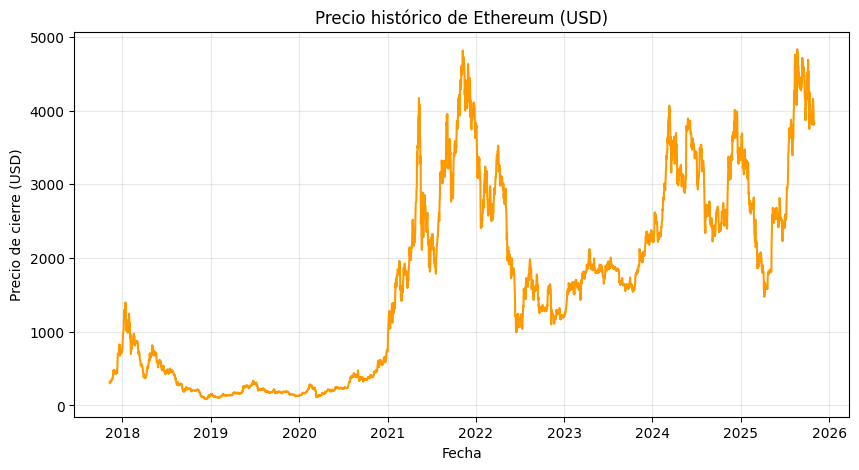

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# ================================================
# Descargar datos históricos de Ethereum
# ================================================
eth = yf.download("ETH-USD", start="2017-01-01", interval="1d")

# Mostrar las primeras filas
print(eth.head())

# Guardar CSV
eth.to_csv("ethereum_historico.csv")
print("✅ Datos guardados como ethereum_historico.csv")

# ================================================
# Graficar cierre histórico
# ================================================
plt.figure(figsize=(10, 5))
plt.plot(eth.index, eth["Close"], color="#FF9900")
plt.title("Precio histórico de Ethereum (USD)")
plt.xlabel("Fecha")
plt.ylabel("Precio de cierre (USD)")
plt.grid(alpha=0.3)
plt.show()


In [4]:
import requests
import pandas as pd

# ==========================================================
# 📊 Obtener datos del Fear & Greed Index de Alternative.me
# ==========================================================
url = "https://api.alternative.me/fng/"
params = {"limit": 1000, "format": "json"}

response = requests.get(url, params=params)

if response.status_code == 200:
    data = response.json()["data"]
    df = pd.DataFrame(data)

    # Convertir tipos y limpiar
    df["timestamp"] = pd.to_datetime(df["timestamp"].astype(int), unit="s")
    df["value"] = pd.to_numeric(df["value"])
    df = df.rename(columns={
        "timestamp": "Date",
        "value": "FearGreed_Value",
        "value_classification": "FearGreed_Label"
    })
    df = df.sort_values("Date")

    # Guardar
    df.to_csv("fear_greed_index.csv", index=False)
    print("✅ Fear & Greed Index descargado correctamente")
    print(df.head())
else:
    print("❌ Error al obtener datos:", response.status_code, response.text)


✅ Fear & Greed Index descargado correctamente
     FearGreed_Value FearGreed_Label       Date time_until_update
999               58           Greed 2023-02-04               NaN
998               58           Greed 2023-02-05               NaN
997               56           Greed 2023-02-06               NaN
996               54         Neutral 2023-02-07               NaN
995               58           Greed 2023-02-08               NaN


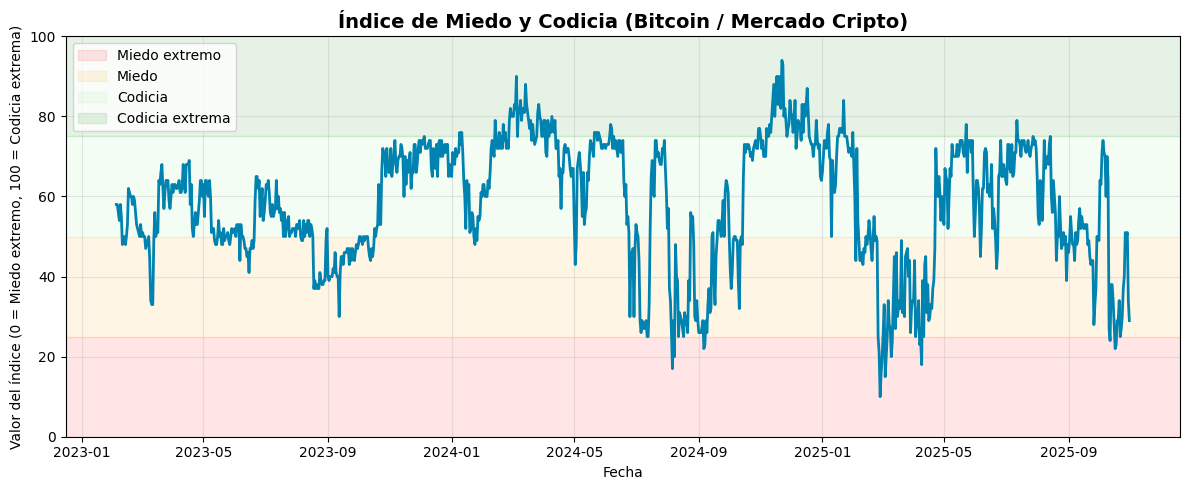

In [5]:
# ==========================================================
# 3️⃣ Gráfica del índice
# ==========================================================
plt.figure(figsize=(12, 5))
plt.plot(df["Date"], df["FearGreed_Value"], color="#0083B0", linewidth=2)
plt.title("Índice de Miedo y Codicia (Bitcoin / Mercado Cripto)", fontsize=14, weight="bold")
plt.xlabel("Fecha")
plt.ylabel("Valor del índice (0 = Miedo extremo, 100 = Codicia extrema)")
plt.grid(alpha=0.3)
plt.ylim(0, 100)

# Colorear zonas
plt.axhspan(0, 25, color="red", alpha=0.1, label="Miedo extremo")
plt.axhspan(25, 50, color="orange", alpha=0.1, label="Miedo")
plt.axhspan(50, 75, color="lightgreen", alpha=0.1, label="Codicia")
plt.axhspan(75, 100, color="green", alpha=0.1, label="Codicia extrema")

plt.legend()
plt.tight_layout()
plt.show()

In [8]:
import requests
import pandas as pd

# ==========================================================
# 1️⃣ Función segura para descargar histórico
# ==========================================================
def get_market_data(coin_id, vs_currency="usd", days="max"):
    """
    Devuelve DataFrame con precio y market cap históricos de una cripto.
    coin_id: 'bitcoin', 'ethereum', etc.
    days: 'max' para todo el histórico disponible.
    """
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    params = {"vs_currency": vs_currency, "days": days}
    r = requests.get(url, params=params)
    data = r.json()

    # --- Validación robusta ---
    if "market_caps" not in data:
        print(f"⚠️ No se encontró 'market_caps' para {coin_id}. Claves disponibles:", list(data.keys()))
        return pd.DataFrame()

    df = pd.DataFrame(data["market_caps"], columns=["timestamp", f"{coin_id}_marketcap_usd"])
    df["Date"] = pd.to_datetime(df["timestamp"], unit="ms")
    df = df.drop(columns=["timestamp"])
    return df

# ==========================================================
# 2️⃣ Descargar datos
# ==========================================================
print("📥 Descargando datos de Bitcoin...")
df_btc = get_market_data("bitcoin")

print("📥 Descargando datos de Ethereum...")
df_eth = get_market_data("ethereum")

# Si alguna descarga falla, avisamos
if df_btc.empty or df_eth.empty:
    raise ValueError("❌ Error al obtener los datos. Comprueba conexión o límites de la API CoinGecko.")

# ==========================================================
# 3️⃣ Fusionar y calcular total market cap y dominancias
# ==========================================================
df_total = pd.merge(df_btc, df_eth, on="Date", how="outer").sort_values("Date")
df_total["total_marketcap_usd"] = df_total["bitcoin_marketcap_usd"].fillna(0) + df_total["ethereum_marketcap_usd"].fillna(0)
df_total["btc_dominance_%"] = (df_total["bitcoin_marketcap_usd"] / df_total["total_marketcap_usd"]) * 100
df_total["eth_dominance_%"] = (df_total["ethereum_marketcap_usd"] / df_total["total_marketcap_usd"]) * 100

# ==========================================================
# 4️⃣ Guardar CSV
# ==========================================================
output_path = "crypto_marketcap_history.csv"
df_total.to_csv(output_path, index=False)

print(f"✅ Histórico completo guardado como: {output_path}")
print(df_total.head())


📥 Descargando datos de Bitcoin...
⚠️ No se encontró 'market_caps' para bitcoin. Claves disponibles: ['error']
📥 Descargando datos de Ethereum...
⚠️ No se encontró 'market_caps' para ethereum. Claves disponibles: ['error']


ValueError: ❌ Error al obtener los datos. Comprueba conexión o límites de la API CoinGecko.